In [2]:
using Distributions, Statistics, StatsPlots, CSV

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken f

In [3]:
include("EDA.jl")

EDA

In [4]:
obj_func(x) = (cdf(LogNormal(x[1], x[2]), 50) - 0.5)^2 + (cdf(LogNormal(x[1], x[2]), 5500) - 0.995)^2
eda_res = EDA(obj_func,[2,2],[4,3], difmax = 0.000000000001)

Iterando... 
...fin
Aviso: se alcanzó el máximo número de iteraciones = 1000


(x = [3.911075542764998, 1.9650320817520337], fx = 1.1366864557173203e-5, iter = 1000)

In [5]:
println(cdf(LogNormal(eda_res[1][1], eda_res[1][2]), 5500))
println(cdf(LogNormal(eda_res[1][1], eda_res[1][2]), 50))

0.9916340136250069
0.5001923545698291


In [6]:
mu = eda_res[1][1]; sigma = eda_res[1][2]; 

freq = NegativeBinomial(3920/17 ,28/45)
sev = LogNormal(mu, sigma)

LogNormal{Float64}(μ=3.911075542764998, σ=1.9650320817520337)

## Simulations of the accidents 

In [7]:
function  simul_events(n)
    S = zeros(n)
    N = rand(freq, n)
    
    N_pos = findall(N .> 0)
    
    for i in N_pos
        Yi = rand(sev, N[i])
        S[i] = sum(Yi)
    end
    return(S, N)
end

simul_events (generic function with 1 method)

In [8]:
#  The exercise ask for 1M simulations
S = simul_events(10_000)

([37548.1270716413, 36761.60081256127, 51059.82456431597, 28523.53383655471, 44660.82391364639, 27736.06396229246, 89501.9588500037, 20171.809010798963, 30469.448926656725, 57026.002339650055  …  62888.98261764674, 37129.92306311095, 38113.953170665845, 39195.102903654915, 47357.42422291751, 31488.92710281552, 21649.24786660482, 51934.94163537612, 43426.60547911877, 31618.375001348424], [152, 129, 131, 114, 144, 157, 154, 128, 147, 146  …  186, 145, 135, 142, 132, 140, 146, 154, 123, 139])

In [9]:
μ0 = mean(log.(S[1]))
n0 = mean(log.(S[2]))

4.93666509102076

In [ ]:
ob2(x) = abs((cdf(LocationScale(μ0,x[1], TDist(x[2])), μ0) - 0.5))
EDA(ob2, [9,4], [13,6])

Iterando... 
...fin
Aviso: se alcanzó el máximo número de iteraciones = 1000


(x = [10.952551776793694, 5.3280986668521635], fx = 0.0, iter = 1000)

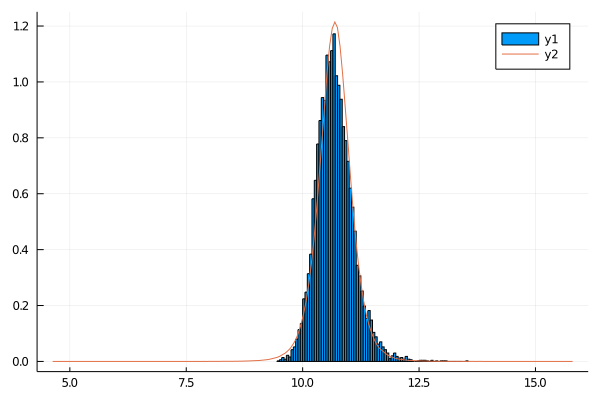

In [10]:
histogram(log.(S[1]), normalize= true)
density!(rand(LocationScale(μ0, 1/sqrt(10.205), TDist(5.71)), 1_000_000))

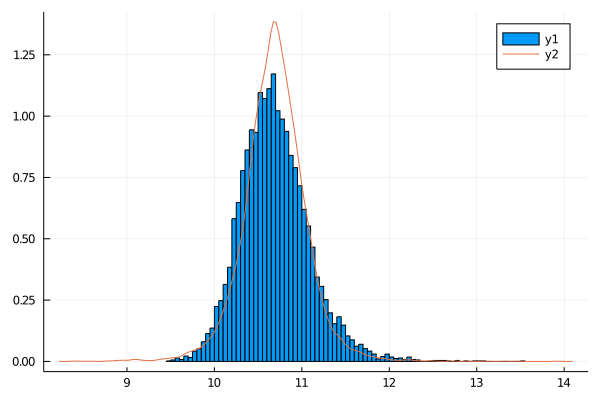

In [11]:
histogram(log.(S[1]), normalize= true)
density!(rand(LocationScale(μ0, 1/sqrt(13.44940881369001), TDist(4.672189981883816)), 10_000))

In [12]:
lns= log.(S[1])

10000-element Array{Float64,1}:
 10.533378777696424
 10.51220912319722
 10.840753254916402
 10.258484774164932
 10.7068519738054
 10.23048879347312
 11.402015790615659
  9.912041315116843
 10.324479786048457
 10.951262624194957
 10.799749856117359
 10.434602058008911
 11.047401997995248
  ⋮
 10.12336655495165
 10.17671086231535
 11.049126270234598
 10.522178475073932
 10.548335719022662
 10.57630709204749
 10.765478880893832
 10.357391242470356
  9.982725992254643
 10.857747091859915
 10.678827561735469
 10.361493717961169

 We use the M(S)

In [13]:
med= median(lns)

10.664167805968546

Let T be a r.v. with distribution t-student ($\alpha$)
$$F_{lnS} ^{-1}(u | \mu,\lambda,\alpha)=\mu + \frac
{1}{\sqrt{\lambda}}F_{T} ^{-1}(u | \mu)$$

In [ ]:
Var75,Var995=quantile(log.(S[1]),0.75),quantile(log.(S[1]),0.995)
print("The VaR at 75% of our sample's log is ", Var75 , " and the VaR at 99.5% is " , Var995)

The VaR at 75% of our sample's log is 10.807592910283638 and the VaR at 99.5% is 11.878150641559982

This implies,
$$10.655=10.429+ \frac
{1}{\sqrt{\lambda}}F_{T} ^{-1}(0.75 | \alpha)$$

$$11.62=10.429+ \frac
{1}{\sqrt{\lambda}}F_{T} ^{-1}(0.995 | \alpha)$$

In [ ]:
difference1,difference2=Var75-med,Var995-med # in order to minimice the difference

(0.24376650113266152, 1.314324232409005)

In [ ]:
difference1*10.807592910283638

2.6345291094060013

In [ ]:
difference2*11.878150641559982

15.611741224406853

Now we estimate the second parameter of the distribution LogNormal. Let 


$$\lambda = \frac{n_{0} \alpha}{(n_{0}+1) \beta }  $$

We use the following expressions 

$$  \alpha = \frac{1}{\sqrt{\lambda}} F^{-1}_{T} (0.75 | \alpha)  $$

$$ 0.2437 = \frac{1}{\sqrt{\lambda}} F^{-1}_{T} (0.75 | \alpha) $$

and 

$$  \sigma = \frac{1}{\sqrt{\lambda}} F^{-1}_{T} (0.995 | \alpha)  $$

$$ 1.3143 = \frac{1}{\sqrt{\lambda}} F^{-1}_{T} (0.995 | \alpha) $$

so

$$ 0.2437  =   \frac{1}{\sqrt{\lambda}} F^{-1}_{T} (0.75 | \alpha) $$
$$  1.3143 = \frac{1}{\sqrt{\lambda}} F^{-1}_{T} (0.995 | \alpha) $$

Insolate the variable lambda 

$$  \lambda =  (\frac{F^{-1}_{T} (0.75 | \alpha)}{0.2437})^2 $$


$$\lambda =  (\frac{F^{-1}_{T} (0.995 | \alpha)}{1.3143})^2$$



We obtain 

$$(\frac{F^{-1}{T} (0.75 | \alpha)}{0.2437})^2 = (\frac{F^{-1}{T} (0.995 | \alpha)}{1.3143})^2 $$

So now we calculte 


$$ | (\frac{F^{-1}{T} (0.75 | \alpha)}{0.2437})^2 - (\frac{F^{-1}{T} (0.995 | \alpha)}{1.3143})^2 | =0 $$

Now, let's see the graph :


In [16]:
f(x)=abs(quantile(TDist(x),0.75)/difference1-quantile(TDist(x),0.995)/difference2)
x=collect(range(2,8,length=1_000))
plot(x,f.(x),legend=false,lw=3,xlabel=L"x",ylabel=L"f(x)")

LoadError: [91mUndefVarError: @L_str not defined[39m

As we can see, the root must be among 5 and 6, so 

In [14]:
α=5
while f(α)>0.0000001 && α<6
    α+= 0.0000001
end 
print(α)

UndefVarError: [91mUndefVarError: f not defined[39m

Thanks to the equations above, we can solve for $\lambda$

$$ \lambda = \left( \frac {F_{T} ^{-1}(0.75 | \alpha=5.3536)}{0.2437}\right)^{2} $$

In [15]:
λ=(quantile(TDist(α),0.995)/difference2)^2

UndefVarError: [91mUndefVarError: difference2 not defined[39m

Now, we obtain $\beta$ 

$$\lambda = \frac{n_{0} \alpha}{(n_{0}+1) \beta }  $$


$$ \beta = \frac{n_{0} \alpha}{(n_{0}+1) \lambda }  $$

In [ ]:
γ= α/2
difference3= λ/γ

3.2867751629060935

We know 

$$2 \alpha = 5.3536 , \lambda = 8.7980 $$

so 

$$\alpha = 2.6768$$

$$ \beta = \frac{n_{0} (5.3536)}{(n_{0}+1) (8.7980) }  $$

In [ ]:
g(x)= abs(x[1]*(γ)/((x[1]+1)*λ)-x[2]) #x[1] is n_0 and x[2] is beta 

g (generic function with 1 method)

In [ ]:
accuracy = EDA(g,[0,0],[10,10])[1] 

Iterando... 
...fin


2-element Vector{Float64}:
 6.470399571243904
 0.2635222394070607

In [ ]:
accuracy[1]/(accuracy[2]*(accuracy[1]+1)) #prove the equality 

3.286775164243201

at this point we already know the hyperparameters

$$  \mu_{0} = 10.563 $$
$$ \lambda = 8.798 $$
$$\beta = 0.263$$
$$n_{0}= 6.470 $$
$$2\alpha =5.353 $$

With distribution 

$$Student(10.563,8.798,5.7197) $$

Let´s find the a posteriori

$$  St (\mu_{m} ,  \frac{(n_{0}+m )(\alpha + m/2)}{(n_{0}+m+1) \beta_{m}} ,  2 \alpha +m)  $$

$$\mu_{m} =  \frac{n_{0} \mu_{0}+m \bar{S} }{n_{0}+m} $$ 

with $m=5$

In [19]:
obs= log.([5223,29487,13498,19462,25466])

5-element Array{Float64,1}:
  8.560827228436299
 10.291704767234739
  9.510296805303351
  9.876219125381935
 10.14509950813338

In [ ]:
param=[med, accuracy[1], accuracy[2], α]

4-element Vector{Float64}:
 10.563826409150977
  6.470399571243904
  0.2635222394070607
  5.353615500991649

In [ ]:
μ_m= (param[2]*param[1]+m*M)/(param[2]+m)

10.177180365678907

In [ ]:
M,m=mean(obs),5

(9.67682948689794, 5)

In [ ]:
varest= (1/(m-1))*((8.560827228436-M)^2+( 10.291704767234739-M)^2+(9.510296805303351-M)^2+(9.876219125381935-M)^2+(10.14509950813338-M)^2)

0.47757470650577744

Now we calculate $\beta_m$

$$\beta_m = \beta +\frac{1}{2} m \hat\sigma^{2} + \frac{1}{2} \frac{n_{0}m(\mu_{0}-\bar{s})^2}{n_{0}+m}$$

and $\sigma^2$

$$\sigma^2=\frac{1}{m-1} \sum_{k=1}^{m} (s_{k}-\bar{s})^2 = 0.477574$$

In [ ]:
#varest= (1/(m-1))* sum(obs[])

In [ ]:
#for i in 1:5 
 #   Sum[i] += (obs[i]-M)^2
#end
#return Sum

In [ ]:
β_m= param[3]+m*varest/2 +(1/2)*(param[2]*m*(param[1]-M)^2)/(param[2]+m)

2.566983229484803

We calculate the second parameter of the a postirior 
$$\frac{(n_{0}+m )(\alpha + m/2)}{(n_{0}+m+1) \beta_{m}}$$

In [ ]:
λ_m = ((param[2]+m)*(γ+5/2))/((param[2]+m+1)*(β_m))

1.8549712515581942

In [ ]:
α_m = param[4]+m

10.353615500991648

We know all parameters of the distribution T-Studen 

$$St (10.1771 , 1.8549  , 10.3536) $$

Now we´re going to calculate the SCR using the M(S)

In [ ]:
MS = median(S)
VaR = quantile(S, 0.995)
println("M(S) = ", MS)
println("99.5% VaR = ", VaR)

LoadError: UndefVarError: S not defined

In [ ]:
SCR = VaR - MS
println("SCR(S) = ", SCR)

LoadError: UndefVarError: VaR not defined

In [24]:
r,i = .11, .049

(0.11, 0.049)

In [18]:
post = LocationScale(10.1771, 1.8549, TDist(10))

LocationScale{Float64,Continuous,TDist{Float64}}(
μ: 10.1771
σ: 1.8549
ρ: TDist{Float64}(ν=10.0)
)


In [21]:
cdf.(post, obs)

5-element Array{Float64,1}:
 0.20199772200795768
 0.5240242007900326
 0.3633548424568892
 0.4371861519006724
 0.49328751938561954

In [25]:
VaR = quantile(post, 0.995)
SCR = VaR - quantile(post, 0.5)
prims = quantile(post, 0.5) + (r - i) * SCR

10.535699716706667

In [26]:
C0 = (1-(r-i))*SCR

5.5200841637305125

In [61]:
function risk_process(t, C0, prims, post)
    sum = 0
    for k in 1:t
       sum =+ rand(post, 1)[1]
      
    end
return C0 + t*prims - sum 
end

risk_process (generic function with 2 methods)

In [62]:
risk_process(1, C0, prims, post)

7.26135238896204

In [70]:
function ruin_prob(simulations , years, C0, prims, post )
    Ct = [risk_process(years, C0, prims, post) for _ in 1:simulations]
    
    return median(Ct)
end

ruin_prob (generic function with 1 method)

In [71]:
ruin_prob(10_000, 1, C0, prims, post)

5.827681931080869